In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

In [31]:
import os
import numpy as np
import scipy.io as spio
 
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''

    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict
 
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''

    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict
 
def sbxread(filename):
    '''
    Input: filename should be full path excluding .sbx
    '''
 # Check if contains .sbx and if so just truncate
    if '.sbx' in filename:
        filename = filename[:-4]

    # Load info
    info = loadmat(filename + '.mat')['info']
    #print info.keys()

    # Defining number of channels/size factor
    if info['channels'] == 1:
        info['nChan'] = 2; factor = 1
    elif info['channels'] == 2:
        info['nChan'] = 1; factor = 2
    elif info['channels'] == 3:
        info['nChan'] = 1; factor = 2

     # Determine number of frames in whole file
    max_idx = os.path.getsize(filename + '.sbx')/info['recordsPerBuffer']/info['sz'][1]*factor/4-1

     # Paramters
    k = 0; #First frame
    N = max_idx; #Last frame

    nSamples = info['sz'][1] * info['recordsPerBuffer'] * 2 * info['nChan']
    #print(nSamples,N)
  
    # Open File
    fo = open(filename + '.sbx')

    # Note: There is a weird inversion that happns thus I am dding the negative sign....
    fo.seek(k*nSamples, 0)
    x = np.fromfile(fo, dtype = 'uint16',count = int(nSamples/2*N))
    print(x.dtype,x.min(),x.max())
    
    x = np.int16((x.max()-x).astype(np.int32)/np.int32(2)) #.astype(np.int16)#+ np.int16(32768)
#     x = ((-1*(x+1)+x.max()+1)/2).astype(np.int16) 
    print(x.dtype,x.min(),x.max())

    x = x.reshape((info['nChan'], info['sz'][1], info['recordsPerBuffer'], int(N)), order = 'F') 
   
    return x

In [54]:
fname = os.path.join("E:","s2p_test2","TwoTower_Timeout_001_020.h5")
sbxname = os.path.join("E:","s2p_test2","TwoTower_Timeout_001_020")
binfile = os.path.join("E:","s2p_test","suite2p","plane0","data_raw.bin")

In [15]:
with open(binfile,'rb') as binary_file:
    buff = binary_file.read()
    data = np.frombuffer(buff,dtype=np.int16,offset=0)
    data = np.reshape(data,(-1,512,796))

In [94]:
print(type(data),data.shape)

<class 'numpy.ndarray'> (23896, 796, 512)


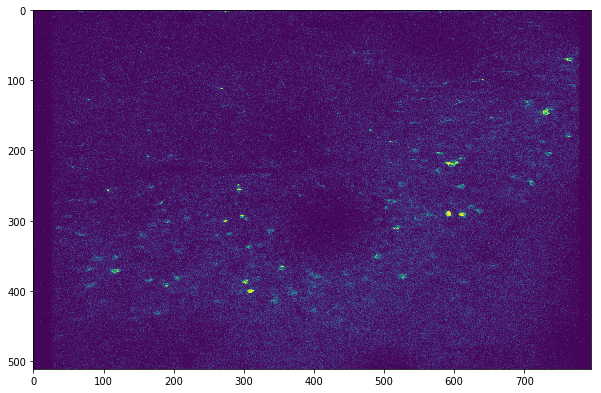

In [16]:
f,ax= plt.subplots(figsize=(10,10))
ax.imshow(data[5000,:,:])

In [86]:
with h5py.File(fname,'r') as f:
    print(f['data'].dtype)
    h5dat = np.array(f['data'][:1000,:,:]).astype(np.int16)
    

int16


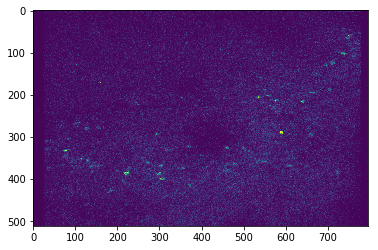

In [87]:
f, ax = plt.subplots()
ax.imshow(data[100,:,:])

In [56]:
# del(sbx_data_raw,sbx_data)
sbx_data_raw = sbxread(sbxname)

uint16 0 65532
int16 0 32766


In [13]:
print(sbx_data_raw.shape)
print(sbx_data_raw.dtype)
print(sbx_data_raw[0,:,:,:500].ravel().min())

(1, 796, 512, 21639)
uint16
0


In [47]:
sbx_data_raw = sbx_data_raw+np.int16(32768)

In [57]:
sbx_data = np.transpose(sbx_data_raw[0,:,:,:] ,axes=(2,1,0))

In [58]:
print(sbx_data.shape)
print(sbx_data.dtype)

(21639, 512, 796)
int16


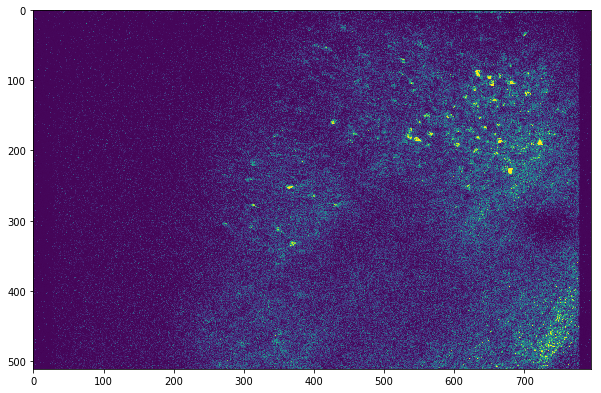

In [59]:
f, ax = plt.subplots(figsize=(10,10))
ax.imshow((sbx_data[1000,:,:]))

In [21]:
print((sbx_data[:5000,:,:]/2).ravel().min())
print((sbx_data[:5000,:,:]/2).ravel().max())

-32717.5
-0.5


In [60]:
f = h5py.File(fname,'w')
dset = f.create_dataset("data",data=sbx_data)


In [61]:
f.close()

In [4]:
base = os.path.join("E:","s2p_test","suite2p","plane0")
spkfile = os.path.join(base,"spks.npy")
icfile = os.path.join(base,"iscell.npy")
Ffile = os.path.join(base,"F.npy")

spks = np.load(spkfile)
iscell = np.load(icfile)
F = np.load(Ffile)

In [5]:
import scipy as sp
from scipy import signal, stats

# preprocessing
F = sp.stats.zscore(sp.signal.medfilt(F,kernel_size=[1,11]),axis=1)

# median filter

# z score

 

In [6]:
print(spks.shape)
print(iscell.shape)

(2494, 23896)
(2494, 2)


In [7]:
print(spks[iscell[:,0]>0,:].shape)

(2021, 23896)


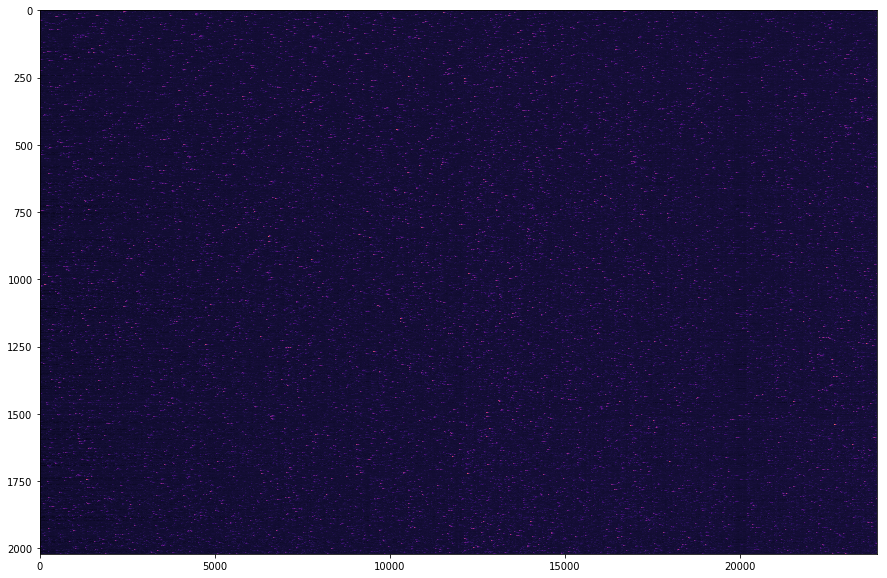

In [8]:
f,ax = plt.subplots(figsize=(15,10))
ax.imshow(F[iscell[:,0]>0,:],aspect='auto',cmap='magma') #,vmin=0,vmax=1)